In [156]:
import sys
sys.path.insert(0, '..')
# from transformer.models import DecoderOnlyModel
from data_utils.Datasets import SerializedConcatDataset, PermSerializedConcatDataset, BinarySerializer
import pickle
import torch
import numpy as np
import os

from transformers import AutoConfig, GPT2LMHeadModel

from bertviz import model_view

import matplotlib.pyplot as plt
import networkx as nx

import pandas
from collections import Counter

import music21 as m21

In [157]:
with open('serializer_cmaj_nottingham.pkl', 'rb') as inp:
    binser = pickle.load(inp)

binser2 = BinarySerializer()

# define model
vocab_size = binser.vocab_size
d_model = 256
num_heads = 4
num_layers = 4
d_ff = 256
max_seq_length = binser.max_seq_length
dropout = 0.3

# dev = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
dev = torch.device("cpu")

config = AutoConfig.from_pretrained(
    "gpt2",
    vocab_size=vocab_size,
    n_positions=max_seq_length,
    n_layer=num_layers,
    n_head=num_heads,
    pad_token_id=binser.padding,
    bos_token_id=binser.padding,
    eos_token_id=binser.padding,
    n_embd=d_ff
)
transformer = GPT2LMHeadModel(config).to(dev)

transformer = transformer.to(dev)

transformer = transformer.to(dev)

saved_model_path = '../saved_models/melboost_cmaj_nottingham_GPT2/melboost_cmaj_nottingham_GPT2.pt'
transformer.load_state_dict(torch.load(saved_model_path, map_location=torch.device(dev)), strict=False)

transformer.eval()

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(30, 256)
    (wpe): Embedding(3795, 256)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-3): 4 x GPT2Block(
        (ln_1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=256, out_features=30, bias=False)
)

In [158]:
# load data
npz_path = '../data/nottingham_c_major.npz'
dataset = SerializedConcatDataset(npz_path, pad_to_length=max_seq_length)

In [159]:
# key finding
def tonality_from_pcp( pcp ):
    major_profile = m21.analysis.discrete.KrumhanslSchmuckler().getWeights('major')
    minor_profile = m21.analysis.discrete.KrumhanslSchmuckler().getWeights('minor')
    major_corrs = np.zeros(12).astype(np.float32)
    minor_corrs = np.zeros(12).astype(np.float32)
    for i in range(12):
        major_corrs[i] = np.corrcoef( pcp, np.roll( 
            major_profile, i ) )[0][1]
        minor_corrs[i] = np.corrcoef( pcp, np.roll( 
            minor_profile, i ) )[0][1]
    major_max_idx = np.argmax( major_corrs )
    minor_max_idx = np.argmax( minor_corrs )
    major_max = np.max( major_corrs )
    minor_max = np.max( minor_corrs )
    if major_max > minor_max:
        return {'root': major_max_idx,
                'mode': 'major',
                'correlation': major_max}
    else:
        return {'root': minor_max_idx,
                'mode': 'minor',
                'correlation': minor_max}
# end tonality_from_pcp

{'root': 0, 'mode': 'major', 'correlation': 0.82963306}
{'root': 0, 'mode': 'major', 'correlation': 0.95008737}


<Axes: >

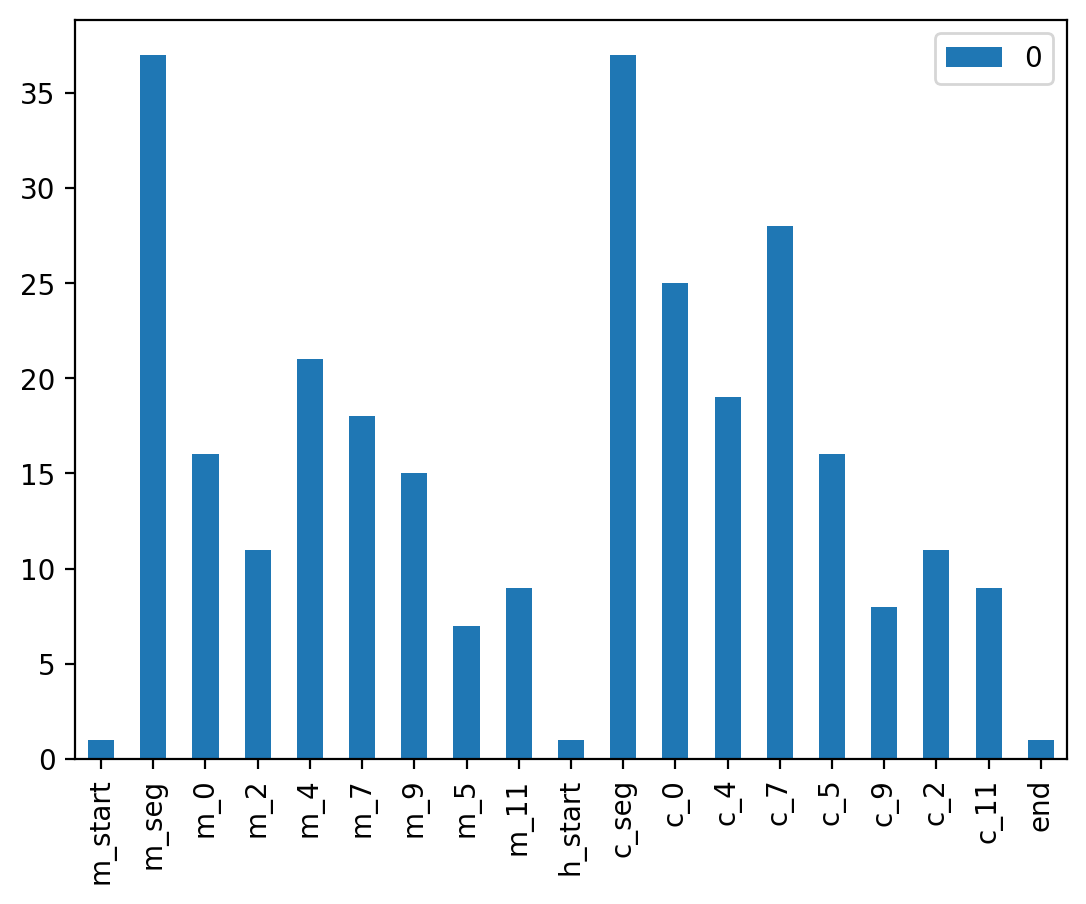

In [160]:
piece_idx = 6
x, mask = dataset.__getitem__(piece_idx)
# find start harmonization index
idx = np.where(x == binser.start_harmonizing)[0][0]
# print(idx)
y = np.pad(x[:idx+1], (x.shape[0]-idx-1, 0))
# remove zeros from the beginning and append them to the end
idx = np.where(y == binser.start_melody)[0][0]
y = np.roll(y, -idx)
idx = np.where(x == binser.start_melody)[0][0]
x = np.roll(x, -idx)

# non-padded matrix
idx_pad = np.where(x == 0)[0][0]
idx_harm = np.where(x == binser.start_harmonizing)[0][0]
x_useful = x[:idx_pad]
tokens = binser2.indexes2labels( x_useful )

tokens_counts = Counter(tokens)

mel_pcp = np.zeros(12)
chr_pcp = np.zeros(12)

for t in tokens_counts.keys():
    if t != 'm_seg' and t != 'm_start' and t[:2] == 'm_':
        mel_pcp[ int(t[2:]) ] = tokens_counts[t]
    if t != 'c_seg' and t[:2] == 'c_':
        chr_pcp[ int(t[2:]) ] = tokens_counts[t]

print( tonality_from_pcp( mel_pcp ) )
print( tonality_from_pcp( chr_pcp ) )

df = pandas.DataFrame.from_dict(tokens_counts, orient='index')
df.plot(kind='bar')

In [161]:
inp = torch.from_numpy( np.expand_dims(x[:-1], axis=0)).to(dev)
output = transformer(inp, attention_mask=inp != 0, output_attentions=True)
a = output.attentions

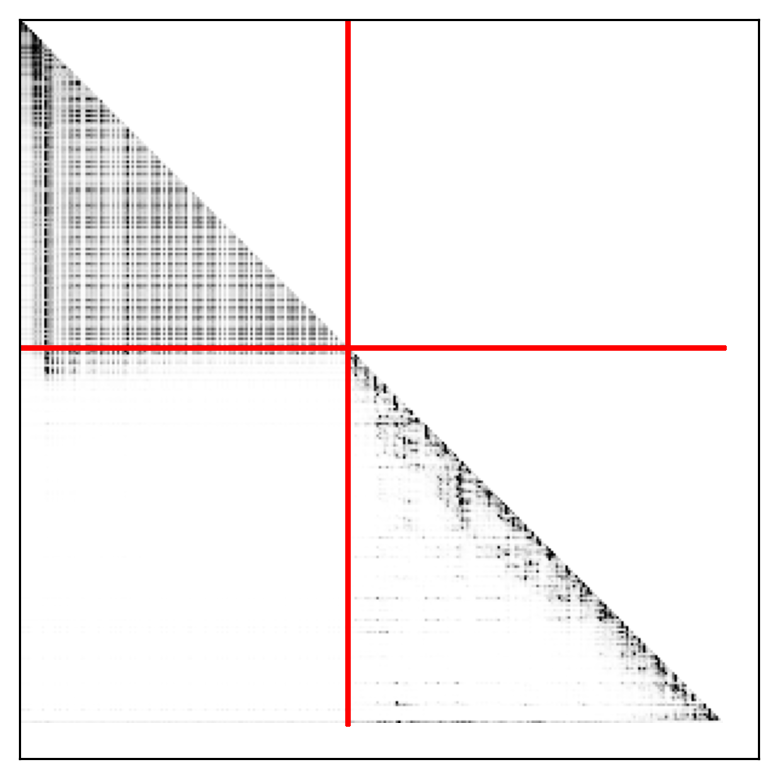

In [162]:
piece_folder = 'figs/piece_' + str(piece_idx) + '/'
os.makedirs(piece_folder, exist_ok=True)

for l in range(4):
    for h in range(4):
        a_np = a[l][0,h,:idx_pad,:idx_pad].cpu().detach().numpy()
        a_np_row_norm = np.array(a_np)
        for r_i in range(a_np_row_norm.shape[0]):
            if np.max( a_np_row_norm[r_i,:] ) > 0:
                a_np_row_norm[r_i,:] = a_np_row_norm[r_i,:]/np.max( a_np_row_norm[r_i,:] )
        # print( np.sum(a_np, axis=1) ) # indeed add to 1
        # plt.subplot(4,4,4*l+h+1)
        # find mean per row
        m = np.mean( a_np, axis=1 )
        # plot values in each row larger than the values in each row
        # plt.imshow( a_np > m[:,None], cmap='gray_r' )
        # plt.imshow( np.log(a_np-np.min(a_np)+0.1), cmap='gray_r' )
        plt.imshow( a_np_row_norm, cmap='gray_r' )
        plt.plot([idx_harm, idx_harm],[0, idx_pad], 'r')
        plt.plot([0, idx_pad],[idx_harm, idx_harm], 'r')
        plt.xticks([])
        plt.yticks([])
        os.makedirs(piece_folder + 'full_attentions/', exist_ok=True)
        plt.savefig( piece_folder + 'full_attentions/' + 'l'+str(l) + '_h'+str(h) + '_att_full.png', dpi=300 )

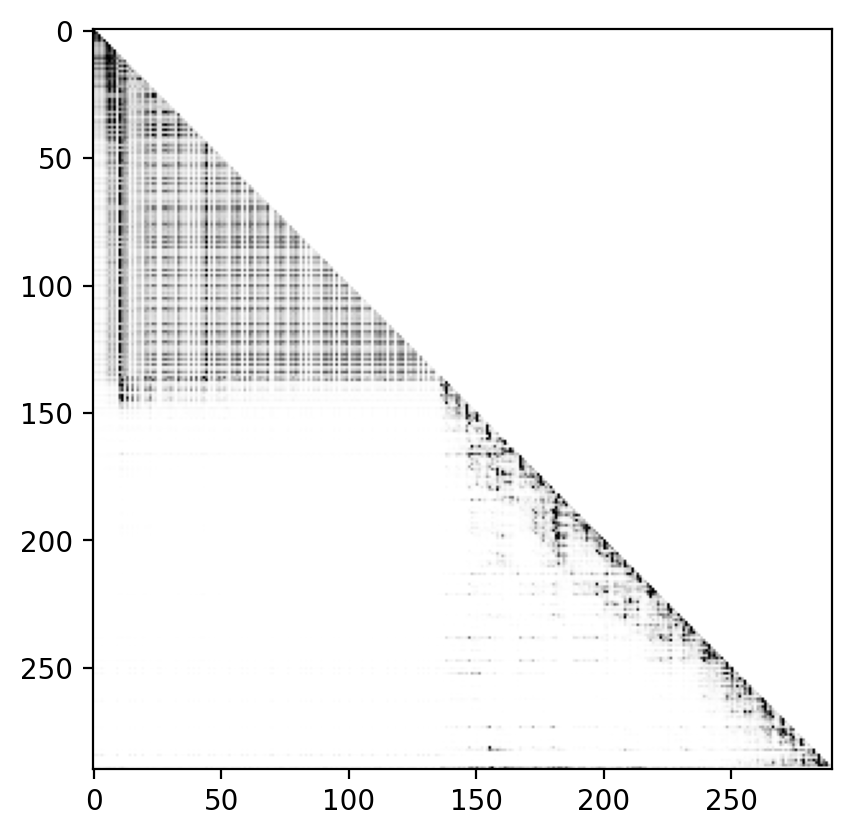

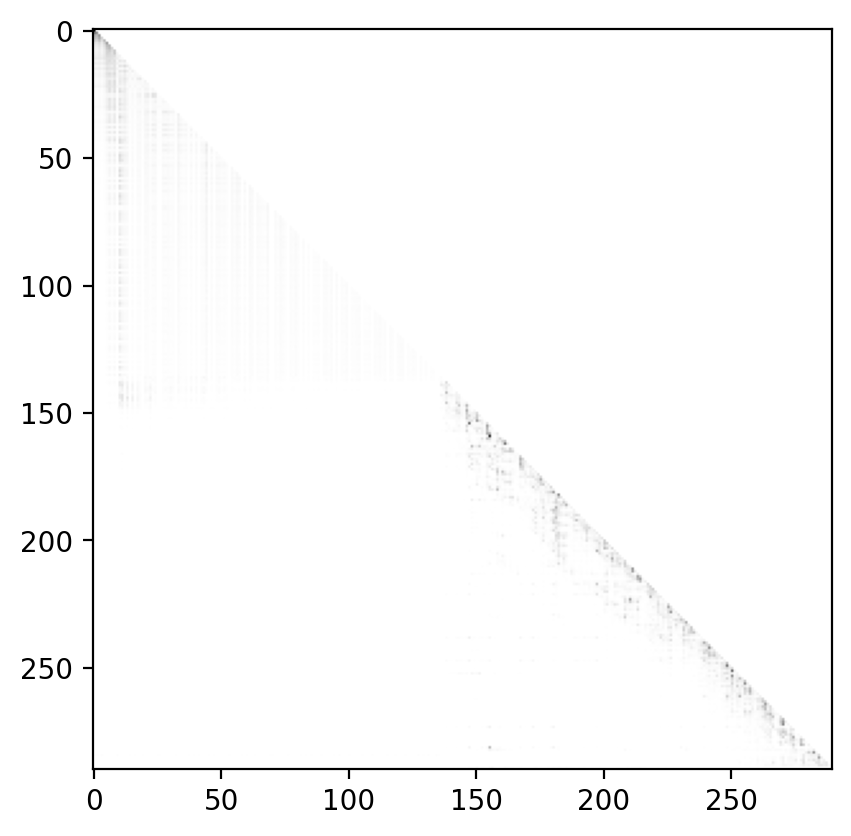

In [163]:
a_np_row_norm = np.array(a_np)
for r_i in range(a_np_row_norm.shape[0]):
    if np.max( a_np_row_norm[r_i,:] ) > 0:
        a_np_row_norm[r_i,:] = a_np_row_norm[r_i,:]/np.max( a_np_row_norm[r_i,:] )
plt.imshow( a_np_row_norm, cmap='gray_r' )
plt.show()
plt.imshow( a_np, cmap='gray_r' )
plt.show()

In [164]:
labels = binser2.indexes2labels( x[:idx_pad] )

# not considering pad - no pad in the sequence
labels_dict = {k: binser2.indexes2labels([k])[0] for k in range(binser2.vocab_size)}
print(labels_dict)

{0: 'pad', 1: 'm_start', 2: 'm_seg', 3: 'm_0', 4: 'm_1', 5: 'm_2', 6: 'm_3', 7: 'm_4', 8: 'm_5', 9: 'm_6', 10: 'm_7', 11: 'm_8', 12: 'm_9', 13: 'm_10', 14: 'm_11', 15: 'h_start', 16: 'c_seg', 17: 'c_0', 18: 'c_1', 19: 'c_2', 20: 'c_3', 21: 'c_4', 22: 'c_5', 23: 'c_6', 24: 'c_7', 25: 'c_8', 26: 'c_9', 27: 'c_10', 28: 'c_11', 29: 'end'}


In [165]:
def reduce_attention(a_np, x_useful, labels_dict, neutralize_diagonal=True, idx_harm=None):
    # delete diagonal
    if neutralize_diagonal:
        np.fill_diagonal(a_np, 0)
    if idx_harm is not None:
        # delete attention between melody parts
        a_np[:idx_harm, :idx_harm] = 0
    # initialize labels
    labels = []
    # first reduce rows
    row_reduced_attention = []
    for i in range(binser2.vocab_size):
        if i in x_useful:
            row_reduced_attention.append( np.mean(a_np[x_useful == i, :], axis=0) )
            labels.append( binser2.indexes2labels( [i] )[0] )
        else:
            row_reduced_attention.append( np.zeros( a_np.shape[1] ) )
    row_reduced_attention = np.array(row_reduced_attention)
    # reduce columns
    reduced_attention = []
    for i in range(binser2.vocab_size):
        if i in x_useful:
            reduced_attention.append( np.mean(row_reduced_attention[:, x_useful == i], axis=1) )
        else:
            reduced_attention.append( np.zeros( row_reduced_attention.shape[0] ) )
    return np.array(reduced_attention).T
# end reduce_attention

def norm_reduce_attention( a_np, x_useful, labels_dict, neutralize_diagonal=True, idx_harm=None ):
    reduced_attention = reduce_attention(a_np, x_useful, labels_dict, neutralize_diagonal=True, idx_harm=idx_harm)
    rows_max = np.amax(reduced_attention, axis=1)
    rows_max[rows_max == 0] = 1
    norm_reduced_attention = reduced_attention/rows_max[:,None]
    return norm_reduced_attention
# end norm_reduce_attention

def make_attention_graph(att, labels_dict, m_th=10):
    m_value = np.sort( att.ravel() )[:-m_th:-1][-1]
    
    adjacency_matrix = att >= m_value
    
    plt.imshow(adjacency_matrix, cmap='gray_r')
    plt.show()
    
    rows, cols = np.where(adjacency_matrix == 1)
    print(rows, cols)
    edges = zip(rows.tolist(), cols.tolist())
    edges_list = list(zip(rows.tolist(), cols.tolist()))
    print(edges_list)
    
    gr = nx.Graph()
    gr.add_nodes_from( labels )
    for edge_idxs in edges_list:
        gr.add_edge( labels_dict[edge_idxs[0]] , labels_dict[edge_idxs[1]] )
    return adjacency_matrix, gr
# end make_attention_graph

In [166]:
tmp_c = [0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,0,0,2,2,2,2,2,2,2,2,2,2,2,2,0]
tmp_x = np.arange(len(tmp_c))
tmp_labels = list(labels_dict.values())

os.makedirs(piece_folder + 'means/', exist_ok=True)
os.makedirs(piece_folder + 'reduced/', exist_ok=True)
os.makedirs(piece_folder + 'per_row/', exist_ok=True)

for l in range(4):
    for h in range(4):
        # weighted graph approach
        a_np = a[l][0,h,:idx_pad,:idx_pad].cpu().detach().numpy()
        
        norm_reduced_attention = norm_reduce_attention(a_np, x_useful, labels_dict, neutralize_diagonal=True, idx_harm=idx_harm)
        plt.imshow( norm_reduced_attention[15:,:] , cmap='gray_r' )
        for ii in range(15):
            plt.plot( [0,len(tmp_c)], [ii,ii], 'k', alpha=0.1 )
        plt.xticks(tmp_x, tmp_labels, rotation='vertical')
        plt.yticks(tmp_x[:15], tmp_labels[15:])
        plt.savefig( piece_folder + 'reduced/' + 'l'+str(l) + '_h'+str(h) + '_att.png', dpi=300 )
        plt.clf()

        # mean of norm_reduced_attention
        mean_norm_reduced_attention = np.mean( norm_reduced_attention, axis=0 )
        plt.scatter(tmp_x, mean_norm_reduced_attention, c=tmp_c, cmap='brg')
        plt.xticks(tmp_x, tmp_labels, rotation='vertical')
        for ii in range(len(tmp_c)):
            if tmp_c[ii] > 0:
                plt.text(ii, mean_norm_reduced_attention[ii], tmp_labels[ii],rotation=90, va='center')
        plt.savefig( piece_folder + 'means/' + 'l'+str(l) + '_h'+str(h) + '_att_mean.png', dpi=300 )
        plt.clf()
        

        for row in range( binser2.start_harmonizing, binser2.end_harmonizing, 1 ):
            print( str(l) + '-' + str(h) + '-' + str(row) )
            tmp_att = np.array(norm_reduced_attention)
            tmp_att[ :row ,:] = 0
            tmp_att[ row+1: ,:] = 0
            G = nx.from_numpy_array(tmp_att, create_using=nx.DiGraph)
            layout = nx.spring_layout(G, k=0.55, iterations=20)
            plt.imshow( tmp_att , cmap='gray_r' )
            plt.yticks([row], [tmp_labels[row]])
            for ii in range(len(tmp_c)):
                if tmp_c[ii] > 0:
                    plt.text(ii, row, tmp_labels[ii],rotation=90, ha='center', va='bottom')
            plt.savefig( piece_folder + 'per_row/' + 'l'+str(l) + '_h'+str(h) + '_r'+str(row) + '_att.png', dpi=300 )
            plt.clf()
            
            for edge in G.edges(data="weight"):
                nx.draw_networkx_edges(G, layout, edgelist=[edge], alpha = (edge[2]/np.max(tmp_att)))
            
            nx.draw_networkx_nodes(G, layout, node_size=5)
            nx.draw_networkx_labels(G,layout, labels=labels_dict)
            plt.savefig( piece_folder + 'per_row/' + 'l'+str(l) + '_h'+str(h) + '_r'+str(row) + '_graph.png', dpi=300 )
            plt.clf()

0-0-15
0-0-16
0-0-17
0-0-18
0-0-19
0-0-20
0-0-21
0-0-22
0-0-23
0-0-24
0-0-25
0-0-26
0-0-27
0-0-28
0-1-15
0-1-16
0-1-17
0-1-18
0-1-19
0-1-20
0-1-21
0-1-22
0-1-23
0-1-24
0-1-25
0-1-26
0-1-27
0-1-28
0-2-15
0-2-16
0-2-17
0-2-18
0-2-19
0-2-20
0-2-21
0-2-22
0-2-23
0-2-24
0-2-25
0-2-26
0-2-27
0-2-28
0-3-15
0-3-16
0-3-17
0-3-18
0-3-19
0-3-20
0-3-21
0-3-22
0-3-23
0-3-24
0-3-25
0-3-26
0-3-27
0-3-28
1-0-15
1-0-16
1-0-17
1-0-18
1-0-19
1-0-20
1-0-21
1-0-22
1-0-23
1-0-24
1-0-25
1-0-26
1-0-27
1-0-28
1-1-15
1-1-16
1-1-17
1-1-18
1-1-19
1-1-20
1-1-21
1-1-22
1-1-23
1-1-24
1-1-25
1-1-26
1-1-27
1-1-28
1-2-15
1-2-16
1-2-17
1-2-18
1-2-19
1-2-20
1-2-21
1-2-22
1-2-23
1-2-24
1-2-25
1-2-26
1-2-27
1-2-28
1-3-15
1-3-16
1-3-17
1-3-18
1-3-19
1-3-20
1-3-21
1-3-22
1-3-23
1-3-24
1-3-25
1-3-26
1-3-27
1-3-28
2-0-15
2-0-16
2-0-17
2-0-18
2-0-19
2-0-20
2-0-21
2-0-22
2-0-23
2-0-24
2-0-25
2-0-26
2-0-27
2-0-28
2-1-15
2-1-16
2-1-17
2-1-18
2-1-19
2-1-20
2-1-21
2-1-22
2-1-23
2-1-24
2-1-25
2-1-26
2-1-27
2-1-28
2-2-15
2-2-16
2-2-17

<Figure size 640x480 with 0 Axes>